<a href="https://colab.research.google.com/github/Dolappo/Disease-Risk-Prediction/blob/main/disease_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.preprocessing import label_binarize

In [4]:
heart_disease = fetch_ucirepo(id=45)

X = heart_disease.data.features
y = heart_disease.data.targets

df = pd.concat([X, y], axis=1)
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [7]:
df["oldpeak"].nunique()

40

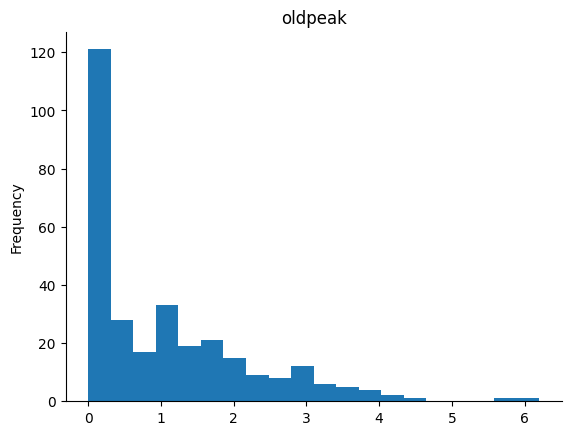

In [8]:

df['oldpeak'].plot(kind='hist', bins=20, title='oldpeak')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
mask_oldpeak = df["oldpeak"] <5
df = df[mask_oldpeak]
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


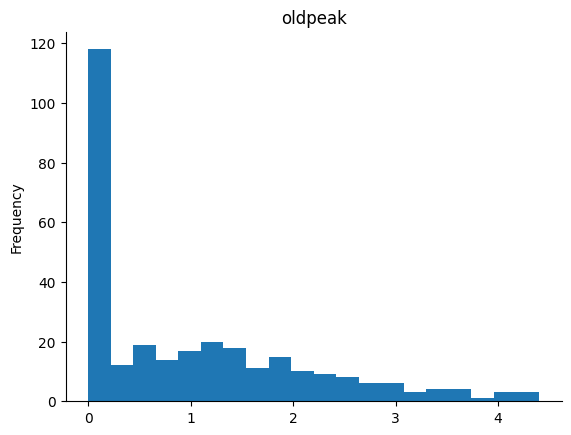

In [10]:
df['oldpeak'].plot(kind='hist', bins=20, title='oldpeak')
plt.gca().spines[['top', 'right',]].set_visible(False)

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    int64  
 2   cp        301 non-null    int64  
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    int64  
 6   restecg   301 non-null    int64  
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    int64  
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    int64  
 11  ca        297 non-null    float64
 12  thal      299 non-null    float64
 13  num       301 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 35.3 KB


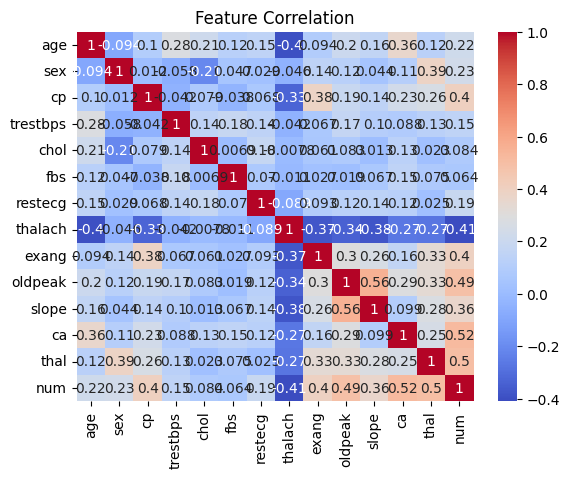

In [51]:
df.info()
df.describe()
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

<Axes: xlabel='oldpeak', ylabel='slope'>

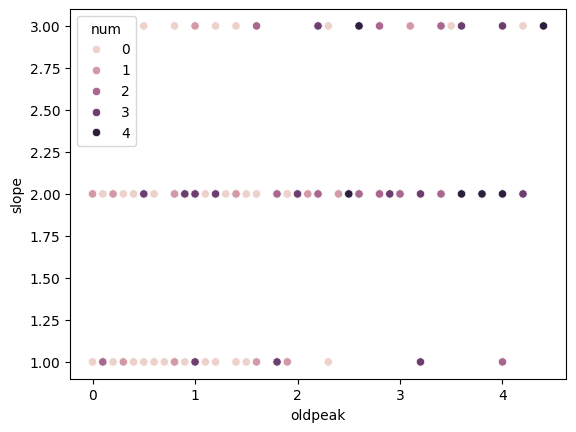

In [52]:
sns.scatterplot(x='oldpeak', y='slope', hue='num', data=df)

In [53]:
df["ca"]= df["ca"].fillna(df["ca"].mean())
df["thal"] = df["thal"].fillna(df["thal"].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    int64  
 2   cp        301 non-null    int64  
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    int64  
 6   restecg   301 non-null    int64  
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    int64  
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    int64  
 11  ca        301 non-null    float64
 12  thal      301 non-null    float64
 13  num       301 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 35.3 KB


In [54]:
X = df.drop('num', axis=1)
y = df['num']

y = (y > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [55]:
# X = df.drop('num', axis=1)
# y = df['num']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )


In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
xgb_model = XGBClassifier( eval_metric='logloss', random_state=42)

xgb_model.fit(X_train, y_train)

xg_y_pred = xgb_model.predict(X_test)
xg_y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, xg_y_pred))
print("Classification Report:\n", classification_report(y_test, xg_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, xg_y_proba))


Accuracy: 0.8032786885245902
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       0.73      0.79      0.76        24

    accuracy                           0.80        61
   macro avg       0.79      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61

ROC AUC Score: 0.8997747747747747


In [63]:
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train_scaled, y_train)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [64]:
rf_y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Probability-based ROC AUC
rf_y_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.8524590163934426
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88        37
           1       0.83      0.79      0.81        24

    accuracy                           0.85        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61

ROC AUC Score: 0.9346846846846847


In [67]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n Evaluation for {name}")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    rf_y_proba = model.predict_proba(X_test)[:, 1]
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)


In [68]:
evaluate_model("Random Forest", y_test, rf_y_pred, rf_y_proba)
evaluate_model("XGBoost", y_test, xg_y_pred, xg_y_proba)


📊 Evaluation for Random Forest
Accuracy: 0.8525
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88        37
           1       0.83      0.79      0.81        24

    accuracy                           0.85        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61

ROC AUC Score: 0.9346846846846847
Confusion Matrix:
 [[33  4]
 [ 5 19]]

📊 Evaluation for XGBoost
Accuracy: 0.8033
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       0.73      0.79      0.76        24

    accuracy                           0.80        61
   macro avg       0.79      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61

ROC AUC Score: 0.8997747747747747
Confusion Matrix:
 [[30  7]
 [ 5 19]]


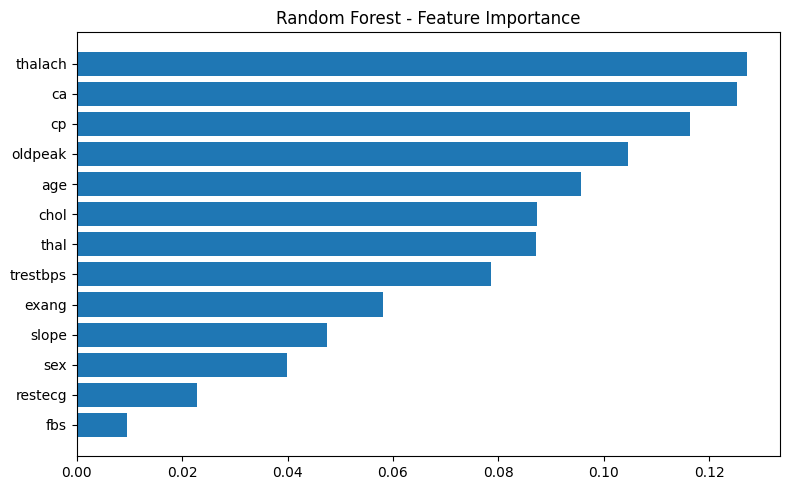

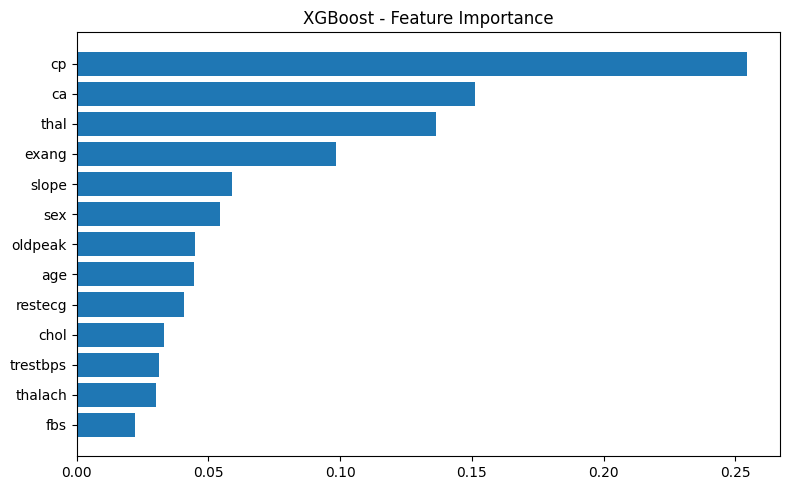

In [69]:
def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    features = X.columns
    df_feat = pd.DataFrame({'Feature': features, 'Importance': importances})
    df_feat = df_feat.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    plt.barh(df_feat['Feature'], df_feat['Importance'])
    plt.title(f"{model_name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, "Random Forest")
plot_feature_importance(xgb_model, "XGBoost")